In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
submission = pd.read_csv('step_1_ qualification/data/sample_submission.csv', index_col=0)
data = pd.read_csv('step_1_ qualification/data/train.csv')
valid = pd.read_csv('step_1_ qualification/data/test.csv')

# Preprocessing

In [3]:
import re
import string
import nltk

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler

In [4]:
def clean(text):
    text = text.lower() # нижний регистр
    # text = re.sub(r'http\S+', " ", text) # удаляем ссылки
    # text = re.sub(r'@\w+',' ',text) # удаляем упоминания пользователей
    # text = re.sub(r'#\w+', ' ', text) # удаляем хэштеги
    text = re.sub(r'\d+', ' ', text) # удаляем числа
    text = text.translate(str.maketrans('', '', string.punctuation))
    # text = re.sub(r'<.*?>',' ', text) # 
    return text

In [5]:
le = LabelEncoder()
data['label'] = le.fit_transform(data.category)
data['clean'] = data.text.apply(clean)
valid['clean'] = valid.text.apply(clean)

In [6]:
labels = data.reset_index()[['category', 'label']].drop_duplicates()
labels.index = labels.label
labels = labels.drop('label', axis=1).to_dict()['category']

In [7]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from nltk.tokenize import RegexpTokenizer

In [8]:
sw = stopwords.words('russian')

sw_removed = []
for text in data.clean:
    sw_removed.append(' '.join([word for word in text.split() if word not in sw]))

In [9]:
stemmer = SnowballStemmer("russian", ignore_stopwords=True)

stemmed_text = []
for text in sw_removed:
    stemmed_text.append(' '.join([stemmer.stem(word) for word in text.split()]))

In [10]:
tokenizer = RegexpTokenizer('\w+')
tokenized_text = tokenizer.tokenize_sents(stemmed_text)

In [11]:
clean_tokenized = [] 
for i, element in enumerate(tokenized_text):
    clean_tokenized.append(' '.join([word for word in element]))

In [12]:
data['clean'] = clean_tokenized
df = data.groupby(['oid','label'])['clean'].apply(lambda x: ','.join(x)).reset_index()

In [13]:
cvec = CountVectorizer(ngram_range=(1, 1)).fit(df['clean'])
tfid = TfidfVectorizer(ngram_range=(1, 1)).fit(df['clean'])

cvec_train = cvec.transform(df['clean'])
tfid_train = tfid.transform(df['clean'])

In [14]:
sw = stopwords.words('russian')
sw_removed = []
for text in valid.clean:
    sw_removed.append(' '.join([word for word in text.split() if word not in sw]))
    
stemmer = SnowballStemmer("russian", ignore_stopwords=True)
stemmed_text = []
for text in sw_removed:
    stemmed_text.append(' '.join([stemmer.stem(word) for word in text.split()]))
    
tokenizer = RegexpTokenizer('\w+')
tokenized_text = tokenizer.tokenize_sents(stemmed_text)

clean_tokenized = [] 
for i, element in enumerate(tokenized_text):
    clean_tokenized.append(' '.join([word for word in element]))
    
valid['clean'] = clean_tokenized

valid = valid.groupby('oid')['clean'].apply(lambda x: ','.join(x)).reset_index()

cvec_test = cvec.transform(valid['clean'])
tfid_test = tfid.transform(valid['clean'])

In [15]:
scaler_cvec = StandardScaler(with_mean=False)
scaler_tfid = StandardScaler(with_mean=False)
scaler_cvec.fit(cvec_train)
scaler_tfid.fit(tfid_train)
cvec_train = scaler_cvec.transform(cvec_train)
tfid_train = scaler_tfid.transform(tfid_train)
cvec_test = scaler_cvec.transform(cvec_test)
tfid_test = scaler_tfid.transform(tfid_test)

# Modeling

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [17]:
lr_cvec = LogisticRegression(penalty='l2',
                             solver='sag', # sag, saga, newton-cg
                             multi_class='multinomial', 
                             fit_intercept=True, 
                             warm_start=True, 
                             max_iter=300).fit(cvec_train, df.label)
y_lr_cvec = lr_cvec.predict_proba(cvec_test)

lr_tfid = LogisticRegression(penalty='l2',
                             solver='sag', # sag, saga, newton-cg
                             multi_class='multinomial', 
                             fit_intercept=True, 
                             warm_start=True, 
                             max_iter=300).fit(tfid_train, df.label)
y_lr_tfid = lr_tfid.predict_proba(tfid_test)

/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/aleksandrabudaeva/miniforge3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
rf_cvec = RandomForestClassifier(n_estimators = 1000,
                                 criterion = 'log_loss',
                                 max_depth = 15, 
                                 warm_start = True).fit(cvec_train, df.label)
y_rf_cvec = rf_cvec.predict_proba(cvec_test)

rf_tfid = RandomForestClassifier(n_estimators = 1000,
                                 criterion = 'log_loss',
                                 max_depth = 15, 
                                 warm_start = True).fit(tfid_train, df.label)
y_rf_tfid = rf_tfid.predict_proba(tfid_test)

In [19]:
cb_cvec = CatBoostClassifier(eval_metric='Accuracy', verbose=100).fit(cvec_train, df.label)
y_cb_cvec = cb_cvec.predict_proba(cvec_test)

cb_tfid = CatBoostClassifier(eval_metric='Accuracy', verbose=100).fit(tfid_train, df.label)
y_cb_tfid = cb_tfid.predict_proba(tfid_test)

Learning rate set to 0.084785
0:	learn: 0.3035622	total: 966ms	remaining: 16m 5s
100:	learn: 0.9235932	total: 1m 36s	remaining: 14m 17s
200:	learn: 0.9610222	total: 3m 16s	remaining: 13m 1s
300:	learn: 0.9736706	total: 4m 55s	remaining: 11m 27s
400:	learn: 0.9821890	total: 6m 21s	remaining: 9m 29s
500:	learn: 0.9876097	total: 7m 49s	remaining: 7m 47s
600:	learn: 0.9914817	total: 9m 16s	remaining: 6m 9s
700:	learn: 0.9945792	total: 10m 40s	remaining: 4m 33s
800:	learn: 0.9963862	total: 12m 5s	remaining: 3m
900:	learn: 0.9981931	total: 13m 29s	remaining: 1m 28s
999:	learn: 0.9989675	total: 15m 11s	remaining: 0us
Learning rate set to 0.084785
0:	learn: 0.3053691	total: 4.32s	remaining: 1h 11m 51s
100:	learn: 0.9266908	total: 4m 53s	remaining: 43m 36s
200:	learn: 0.9638616	total: 9m 48s	remaining: 39m
300:	learn: 0.9765101	total: 14m 40s	remaining: 34m 4s
400:	learn: 0.9852865	total: 19m 49s	remaining: 29m 37s
500:	learn: 0.9917398	total: 24m 29s	remaining: 24m 24s
600:	learn: 0.9961280	to

In [20]:
lgbm_cvec = LGBMClassifier(n_estimators=350, learning_rate=0.04, num_leaves=45, n_jobs=2).fit(cvec_train, df.label)
y_lgbm_cvec = lgbm_cvec.predict_proba(cvec_test)

lgbm_tfid = LGBMClassifier(n_estimators=350, learning_rate=0.04, num_leaves=45, n_jobs=2).fit(tfid_train, df.label)
y_lgbm_tfid = lgbm_tfid.predict_proba(tfid_test)

In [21]:
xgb_cvec = XGBClassifier(n_estimators=300, max_depth=5, max_leaves=10, learning_rate=0.1).fit(cvec_train, df.label)
y_xgb_cvec = xgb_cvec.predict_proba(cvec_test)

xgb_tfid = XGBClassifier(n_estimators=300, max_depth=5, max_leaves=10, learning_rate=0.1).fit(tfid_train, df.label)
y_xgb_tfid = xgb_tfid.predict_proba(tfid_test)

# Results

In [22]:
results = np.array([y_lr_cvec, y_lr_tfid, 
                    y_rf_cvec, y_rf_tfid, 
                    y_cb_cvec, y_cb_tfid,
                    # y_lgbm_cvec, y_lgbm_tfid,
                    # y_xgb_cvec, y_xgb_tfid
                   ])

In [23]:
results_r = np.array([np.mean(np.array([array[:,col] for array in results]), axis=0) for col in np.arange(13)])

In [31]:
my_submission = pd.DataFrame(np.argmax(results_r, axis=0), index=valid.oid, columns=['category'])
my_submission['category'] = my_submission.category.map(labels)
my_submission['prob'] = np.max(results_r, axis=0)
my_submission = my_submission[my_submission.prob >= 0.20]
my_submission = my_submission.drop('prob', axis=1)
my_submission.to_csv('data/submission.csv')
my_submission.head()

,category
oid,
1622114,athletics
1663817,autosport
3174332,basketball
3469228,extreme
3905302,boardgames


# Testing

In [87]:
X_train, X_test, y_train, y_test = train_test_split(cvec_train, df.label, test_size=0.2, random_state=42)

In [94]:
def objective(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'max_leaves': trial.suggest_int('max_leaves', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1),
    }

    model = XGBClassifier(**param_grid)
    model.fit(X_train, y_train)
    
    return accuracy_score(y_test, model.predict(X_test))

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective, n_trials=20)

[I 2022-12-15 18:56:53,067] A new study created in memory with name: no-name-7daacd37-ef91-4623-a398-d2e6ada15e9f
[I 2022-12-15 18:57:09,908] Trial 0 finished with value: 0.9303225806451613 and parameters: {'n_estimators': 74, 'max_depth': 7, 'max_leaves': 11, 'learning_rate': 0.07359422477809749}. Best is trial 0 with value: 0.9303225806451613.
[I 2022-12-15 18:57:22,251] Trial 1 finished with value: 0.8993548387096775 and parameters: {'n_estimators': 43, 'max_depth': 8, 'max_leaves': 19, 'learning_rate': 0.04459236920661935}. Best is trial 0 with value: 0.9303225806451613.
[I 2022-12-15 18:57:53,504] Trial 2 finished with value: 0.9380645161290323 and parameters: {'n_estimators': 114, 'max_depth': 9, 'max_leaves': 3, 'learning_rate': 0.06866709607835964}. Best is trial 2 with value: 0.9380645161290323.
[I 2022-12-15 18:58:42,853] Trial 3 finished with value: 0.9380645161290323 and parameters: {'n_estimators': 211, 'max_depth': 8, 'max_leaves': 6, 'learning_rate': 0.050330118108468304

In [95]:
study_xgb.best_params

{'n_estimators': 300,
 'max_depth': 3,
 'max_leaves': 7,
 'learning_rate': 0.09647378121118468}

0.944516129032258


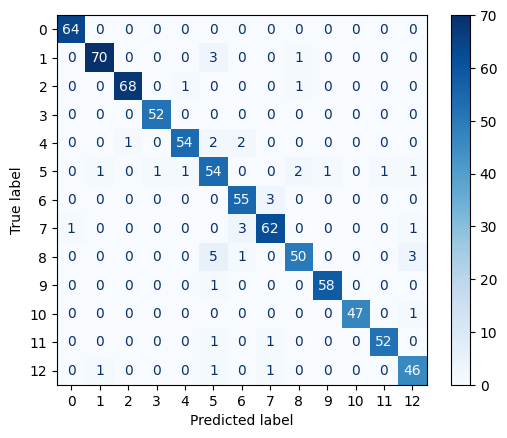

In [96]:
# 0.87
model = XGBClassifier(n_estimators=300, max_depth=5, max_leaves=10, learning_rate=0.1).fit(X_train, y_train)

print(accuracy_score(y_test, model.predict(X_test)))

plot_confusion_matrix(model, X_test, y_test, cmap='Blues')
plt.show()